# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-16 05:30:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  74.6MB/s    in 2.7s    

2023-10-16 05:30:44 (74.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

Сначала предобработаем данные

In [ ]:
X_train = scaler.fit_transform(X_train) #обучили Standard Scaler на  тренировочной выборке и преобразовали ее

In [ ]:
X_test = scaler.transform(X_test) #преобразовали тестовую выборку

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
const_predict = np.mean(y_test)
predicted = np.full(shape=y_test.shape[0], fill_value = const_predict)
const_error = np.sqrt(mean_squared_error(y_test, predicted))

In [ ]:
const_error

10.851909820717683

In [ ]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
print('Средняя ошибка для модели:', rmse_for_model)

Средняя ошибка для модели: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
const_predict = np.mean(y_test) #завели значение среднего
predicted = np.full(shape=y_test.shape[0], fill_value = const_predict) #массив со значением среднего

In [ ]:
best_rmse_metric = np.sqrt(mean_squared_error(y_test, predicted))

In [ ]:
print('Ошибка при лучшей метрике:', best_rmse_metric)

Ошибка при лучшей метрике: 10.851909820717683


Мы получили, что ошибка при Ridge-регрессии ниже, чем при константном прогнозе, что в целом справедливо, так как в первом случае мы обучаем модель и она подстраивается под наши значения.

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
model_1 = nn.Sequential(nn.Linear(X_train.shape[1], 1))

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model_1 = nn.Sequential(nn.Linear(X_train.shape[1], 1)) #одна и та же модель два раза, но она хотя бы работает...


In [ ]:
train_loss = [] #здесь я буду хранить все наши ошибки (считала mse loss)
val_loss = []

Пример цикла был взят из семинара, и на его основании как раз-таки и написан циклл с "собственным оптимайзером" - линейной регрессией

In [ ]:
for epoch in range(10):
  train_l = 0 #буду считать суммарную ошибку, тк с добавлением массива уже было невыносимо ждать
  i = 0
  for x, y in tqdm(train_dataloader):
    i += 1
    y_pred = model_1(x.to(device))
    loss = ((y - y_pred) ** 2).mean()
    loss.backward()
    train_l += loss.item()  # считаем градиенты обратным проходом
    with torch.no_grad():
      for p in model_1.parameters():
        new_val = p - 0.01 * p.grad
        p.copy_(new_val)
      model_1.zero_grad()
  train_loss.append(train_l / i)
  val_l = 0
  j = 0
  with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
          for x_val, y_val in tqdm(test_dataloader):  # берем батч из валидационного лоадера
              y_pred = model_1(x_val.to(device))  # делаем предсказания
              loss = ((y_val - y_pred) ** 2).mean()  # считаем лосс
              val_l += loss.item()
              j += 1
  val_loss.append(val_l/j)

  print(
            f"Epoch: {epoch}, test_loss: {np.mean(val_l)}, train_loss: {np.mean(train_l)}"
        )

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 0, test_loss: 92913.62905883789, train_loss: 118936432.29118967


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 1, test_loss: 92913.47157669067, train_loss: 865779.3697524071


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 2, test_loss: 92913.4702372551, train_loss: 865779.2566423416


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 3, test_loss: 92913.46990585327, train_loss: 865779.2793354988


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 4, test_loss: 92913.47119903564, train_loss: 865779.2599687576


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 5, test_loss: 92913.47102832794, train_loss: 865779.2755479813


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 6, test_loss: 92913.47176885605, train_loss: 865779.2649316788


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 7, test_loss: 92913.47126197815, train_loss: 865779.2597589493


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 8, test_loss: 92913.47060632706, train_loss: 865779.2606859207


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch: 9, test_loss: 92913.47167444229, train_loss: 865779.2731690407


PS: при перезапуске очень важно обновить ячейку с моделью!! Иначе веса останутся старые и все пойдет очень грустно🥰


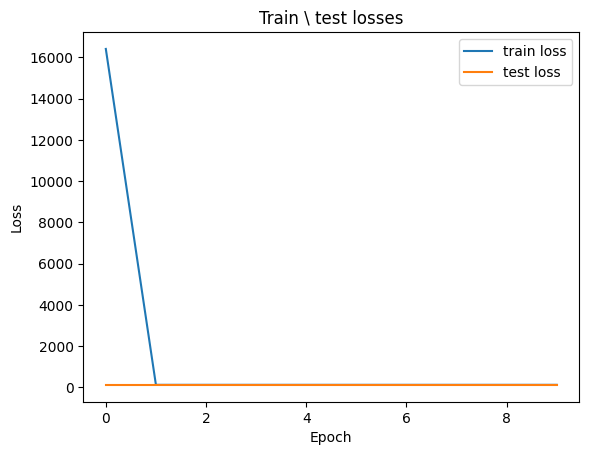

In [ ]:
plt.title('Train \ test losses')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(10), train_loss, label = "train loss")
plt.plot(range(10), val_loss, label = "test loss")
plt.legend()
plt.show()

Оно работает хоть как-то, на этом спасибо, всем пока🤕

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

не злитесь, пожалуйста, я уже ничего не понимаю, у меня лапки🐣

https://discuss.pytorch.org/t/rmse-loss-function/16540/2
вот отсюда украла RMSELoss()

In [ ]:
class RMSELoss(torch.nn.Module): #создала класс для ошибки rmse
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
pred_scaler = StandardScaler()
target_scaler = StandardScaler()
X_train = pred_scaler.fit_transform(X_train)
y_train = target_scaler.fit_transform(y_train.reshape(-1, 1))
X_test = pred_scaler.transform(X_test)
y_test = target_scaler.transform(y_test.reshape(-1, 1))

In [ ]:
scale = target_scaler.scale_[0] # потребуется нам для вывода реальной rmse

In [ ]:
train_set = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_set = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(X_train.shape[1], 90),
                      nn.Dropout(0.3),
                      nn.LeakyReLU(),
                      nn.Linear(90, 30),
                      nn.BatchNorm1d(30),
                      nn.LeakyReLU(),
                      nn.Linear(30, 1)
        )

    def forward(self, X):
        step = torch.flatten(X, start_dim=1)
        return self.model(step).float()

In [ ]:

model = Model()
сriterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, optimizer, criterion, train_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    current_loss = 0
    for x, y in tqdm(train_loader, desc='Training'):
      optimizer.zero_grad()
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      current_loss += loss.item() * x.size(0)
    print(
        f"Loss: {np.sqrt((current_loss)/len(train_loader.dataset))}"
    )


def test(model, criterion, test_loader, target_scaler):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    current_loss = 0
    j = 0
    with torch.no_grad():
      for x, y in tqdm(test_loader, desc='Validating'):
        outputs = model(x)
        y = target_scaler.inverse_transform(y.reshape(-1, 1))
        y = torch.Tensor(y)
        outputs = target_scaler.inverse_transform(outputs.reshape(-1, 1).detach().numpy())
        outputs = torch.Tensor(outputs)

        loss = criterion(outputs, y)
        current_loss += loss.item() * x.size(0)
        if j == 0:
          predicts = outputs
        else:
          predicts = torch.cat((predicts, outputs))
        j += 1
    rmse = np.sqrt((current_loss)/len(test_loader.dataset))
    print(
        f"Loss: {rmse}"
    )
    return rmse, predicts

**Перезапускать лучше с перезапуском модели и нормализации исходно**

In [ ]:
rmse_values = []
epochs = range(20)
for epoch in epochs:
    model.train()
    train(model, optimizer, сriterion, train_loader)

    model.eval()
    rmse, predicts = test(model, сriterion, test_loader, target_scaler)
    rmse_values.append([epoch, rmse])
rmse_values

Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.8328152963551902


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.906143266550504


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.8125204904597517


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.83982764355267


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.8076083049954178


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.82607519748703


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.8044901865253656


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.80010624961497


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.8018453688291276


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.781496961982844


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7999167612294142


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.778583981130817


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7985540675300689


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.784082022518787


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7969848469884596


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.771010337520039


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7960878767770984


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.770810716414008


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7951979676094708


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.75602900914759


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7943180727896185


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.765730362609027


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7936745730685207


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.756317375572086


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7929734509755761


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.743923541132947


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.792668953047667


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.758253481232554


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7919961079423635


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.74196207402764


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7912845287858015


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.7553485798885


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7905364918216725


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.750569458953487


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7903459065605922


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.743317138416941


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.789687948052971


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.743658904593826


Training:   0%|          | 0/3623 [00:00<?, ?it/s]

Loss: 0.7895690637007272


Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.732237877320536


[[0, 8.906143266550504],
 [1, 8.83982764355267],
 [2, 8.82607519748703],
 [3, 8.80010624961497],
 [4, 8.781496961982844],
 [5, 8.778583981130817],
 [6, 8.784082022518787],
 [7, 8.771010337520039],
 [8, 8.770810716414008],
 [9, 8.75602900914759],
 [10, 8.765730362609027],
 [11, 8.756317375572086],
 [12, 8.743923541132947],
 [13, 8.758253481232554],
 [14, 8.74196207402764],
 [15, 8.7553485798885],
 [16, 8.750569458953487],
 [17, 8.743317138416941],
 [18, 8.743658904593826],
 [19, 8.732237877320536]]

In [ ]:
rmse_val = []
for i in range(20):
  rmse_val.append(rmse_values[i][1])
rmse_val

[8.906143266550504,
 8.83982764355267,
 8.82607519748703,
 8.80010624961497,
 8.781496961982844,
 8.778583981130817,
 8.784082022518787,
 8.771010337520039,
 8.770810716414008,
 8.75602900914759,
 8.765730362609027,
 8.756317375572086,
 8.743923541132947,
 8.758253481232554,
 8.74196207402764,
 8.7553485798885,
 8.750569458953487,
 8.743317138416941,
 8.743658904593826,
 8.732237877320536]

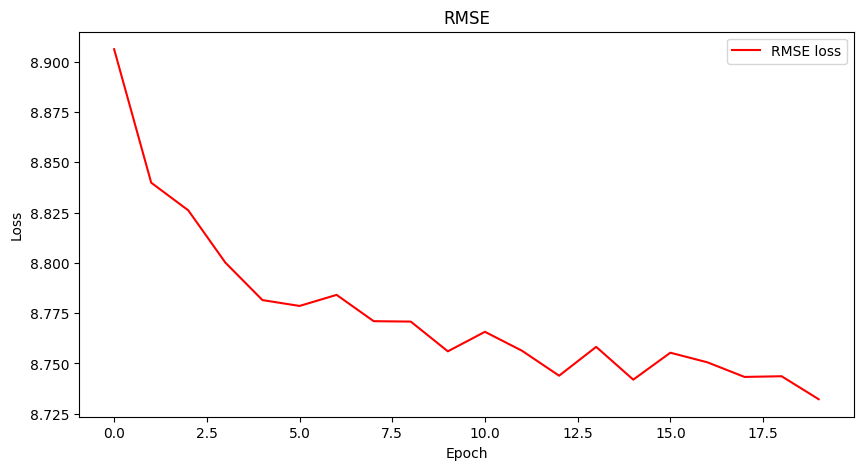

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('RMSE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs, rmse_val, label = "RMSE loss", c='r')
plt.legend()

In [ ]:
assert test(model, сriterion, test_loader, target_scaler)[1].shape[0] == y_test.shape[0]

Validating:   0%|          | 0/404 [00:00<?, ?it/s]

Loss: 8.732237877320536


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1.  Сначала я "поигралась" с оптимизатором и вышло так, что при SGD очень падает качество на высших эпохах и это связано, скорее всего с его стохастичностью (о чем не раз было сказано на лекциях, что ближе к истине мы начинаем сильно отклоняться), поэтому было решено взять оптимайзер функции Адама, так как он менее смещается в сторону. При той же модели и SGD с lr=0.01 лучшим результатом была метрика 8.96
2. Далее уже начинала рассматривать модели, здесь, объективно говоря, присутствовала доля "я так чувствую", но хочу сказзать, что при LeakyRelu модель вела себя более стабильно на последних эпохах и значение стремилось к 8.77-8.78 , а не к 8.799, как при простом Relu(). Также был использован Dropout как очень полезная и тоже уменьшающая разбросы "регулязация".
3. Еще я поигралась с размерами батчей и наилучшие результаты у меня выходили при значении 128, а не меньшем (64 и 32 давали больше 9, что совсем не годилось). Shuffle=True и модель даже вела себя интереснее
4. Полносвязные слои : добавление самого первого прямо круто изменило rmse в лучшую сторону, даже выходило 8.7456 и ниже, ну что-то точно есть) + Помогло Batchnorm(), так что все вышло так, как вышло
5. 20 эпох -- если бы оставила 10, как в первом номере (а я постепенно потом начала увеличивать, сначала до 14 итд), то вряд ли бы получилось 8,73


**Спасибо за внимание, у меня все🥰**